## Problem 1

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from dscribe.descriptors import CoulombMatrix
from ase.io.xyz import read_xyz
from io import StringIO
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import perf_counter

In [2]:
data = pd.read_json('Downloads/qm9.json.gz', lines=True)

In [3]:
data['atoms'] = data['xyz'].map(lambda x: next(read_xyz(StringIO(x), slice(None))))
cm = CoulombMatrix(40, permutation='eigenspectrum', flatten=False)
cms = cm.create(data['atoms'])
data['cm']=cms

In [4]:
train_data, test_data = train_test_split(data, test_size=1000)
train_data['cm'].tolist()
qwerty=42 #just because I'm annoyed with the output showing every single time I call this cell
#mudar test_size para 1000 depois

In [5]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('krr', KernelRidge(kernel='rbf'))
])

gs = GridSearchCV(model,
    {'krr__gamma': np.logspace(-6, 0, 16), 'krr__alpha': np.logspace(-6, 0, 16)},
    cv=10,
    scoring='neg_mean_squared_error'
)

#mudar para logspace(-6, 0, 16)

In [6]:
mae = []
alpha = []
gamma =[]

train_subset = train_data.sample(1600, random_state=1)

for i in range(16):
    gs.fit(np.vstack(train_subset['cm'][i*100:(i+1)*100]), train_subset['homo'][i*100:(i+1)*100])
    best_gs = gs.best_estimator_
    y_pred = best_gs.predict(np.vstack(test_data['cm']))
    alpha.append(gs.best_params_['krr__alpha'])
    gamma.append(gs.best_params_['krr__gamma'])
    mae.append(mean_absolute_error(y_pred, test_data['homo']))

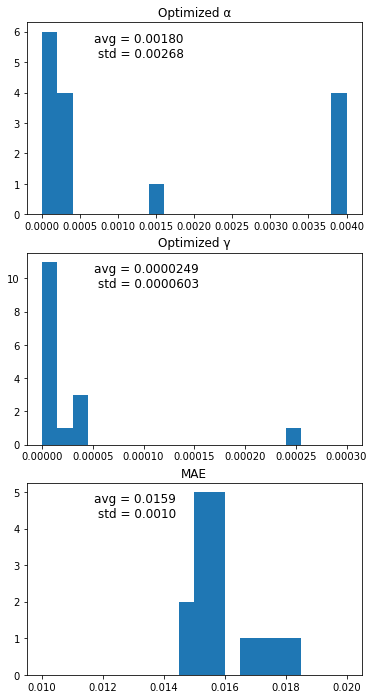

In [10]:
fig = plt.figure(figsize = (6,12))
ax =fig.add_subplot(3,1,1)
ay =fig.add_subplot(3,1,2)
az =fig.add_subplot(3,1,3)

avg_alpha=np.average(alpha)
std_alpha=np.std(alpha)
avg_gamma=np.average(gamma)
std_gamma=np.std(gamma)
avg_mae=np.average(mae)
std_mae=np.std(mae)

textfit = 'avg = {:.5f} \n std = {:.5f}'.format(avg_alpha, std_alpha)
ax.text(0.2, 0.95, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

textfit = 'avg = {:.7f} \n std = {:.7f}'.format(avg_gamma, std_gamma)
ay.text(0.2, 0.95, textfit, transform=ay.transAxes , fontsize=12,verticalalignment='top')

textfit = 'avg = {:.4f} \n std = {:.4f}'.format(avg_mae, std_mae)
az.text(0.2, 0.95, textfit, transform=az.transAxes , fontsize=12,verticalalignment='top')

ax.hist(alpha, bins=20, range=(0, 0.004))
ax.set_title('Optimized α')
ay.hist(gamma, bins=20, range=(0, 0.0003))
ay.set_title('Optimized γ')
az.hist(mae, bins=20, range=(0.01, 0.02))
az.set_title('MAE')

plt.savefig('histograms.pdf')

The optimized hyperparameters vary for each run, and the standard deviation is of the same order of magnitude as the average value, which shows that the optimization depends a lot on the training set.

## Problem 2

In [11]:
train_sizes = [10, 100, 1000]
results = []
for i in range(4):
    for ts in tqdm(train_sizes):
        train_subset = train_data.sample(ts, random_state=1)
    
        train_time = perf_counter()
        gs.fit(np.vstack(train_subset['cm']), train_subset['homo'])
        train_time = perf_counter() - train_time
    
        test_time = perf_counter()
        test_data['homo_pred'] = gs.predict(np.vstack(test_data['cm']))
        test_time = perf_counter() - test_time
    
        results.append({
            'train_size': ts,
            'train_time': train_time,
            'test_time': test_time,
            'mae': mean_absolute_error(test_data['homo'], test_data['homo_pred'])
        })

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]C:\Users\joaoh\Downloads\applied-ai-for-materials-main\molecular-property-prediction\env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
 33%|████████████████████████████                                                        | 1/3 [00:06<00:12,  6.41s/it]C:\Users\joaoh\Downloads\applied-ai-for-materials-main\molecular-property-prediction\env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [12]:
results = pd.DataFrame(results)
results = results.groupby('train_size', as_index=False)['train_time', 'test_time', 'mae'].mean()

C:\Users\joaoh\Downloads\applied-ai-for-materials-main\molecular-property-prediction\env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


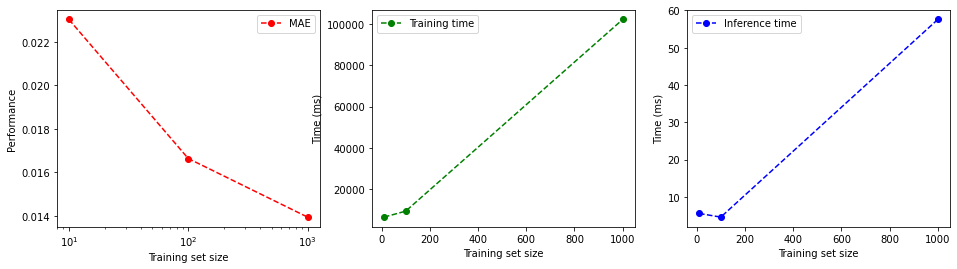

In [15]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,3,1)
ay = fig.add_subplot(1,3,2)
az = fig.add_subplot(1,3,3)


ax.plot(results['train_size'], results['mae'], 'r--o', label="MAE")
ay.plot(results['train_size'], results['train_time']*1000, 'g--o', label="Training time")
az.plot(results['train_size'], results['test_time']*1000, 'b--o', label = "Inference time")

ax.set_xlabel('Training set size')
ay.set_xlabel('Training set size')
az.set_xlabel('Training set size')
ax.legend()
ay.legend()
az.legend()
ax.set_ylabel('Performance')
ay.set_ylabel('Time (ms)')
az.set_ylabel('Time (ms)')
ax.set_xscale('log')
#ay.set_xscale('log')
#az.set_xscale('log')
#ay.set_yscale('log')
#az.set_yscale('log')

plt.savefig('3charts.pdf')

## Problem 3

In [46]:
valid_data=train_data.sample(1000)

#mudar para 1000

In [53]:
def evaluate_subset(points: list, model, train_data: pd.DataFrame, test_data: pd.DataFrame) -> float:
   
    train_subset = train_data.iloc[points]
    model.fit(np.vstack(train_subset['cm']), train_subset['homo'])
    y_pred = model.best_estimator_.predict(np.vstack(test_data['cm']))
    return -mean_absolute_error(y_pred, test_data['homo'])

In [48]:
from random import sample

def mutate(points: set, total: int, fraction: float = 0.1) -> set:
    """Mutate a set of points
    
    Mutates from selecting points randomly from the dataset
    
    Args:
        points: Set of points to be mutated
        total: Total number of samples to choose from in dataset
        fraction: How many points to re-select
    """
    
    # Remove the desired amount of points
    n_to_remove = int(len(points) * fraction)
    to_remove = sample(points, k=n_to_remove)
    new_points = points.difference(to_remove)
    
    # Add more points to the set
    available_choices = set(range(total)).difference(new_points)
    new_points.update(sample(available_choices, n_to_remove))
    
    return new_points

def crossover(parent_a: set, parent_b: set):
    """Perform a crossover operation
    
    Randomly chooses points from both parents
    
    Args:
        parent_a: One choice of points
        parent_b: Another choice of points
    Returns:
        A new set that combines both parents
    """
    
    # Combine all points from each parents
    options = parent_a.union(parent_b)
    
    # Pick randomly from the combined set
    return set(sample(options, len(parent_a)))

In [58]:
# Defining options
n_generations = 50
pop_size = 8
dataset_size = 100

# Array in which to store all results
all_options = []

# Make an initial population
#  Creates sets where each have different entries pull from the full dataset
population = np.array([set(sample(range(len(train_data)), k=100)) for i in range(pop_size)])
#mudar para k=100

# Loop over the generations
for gen in tqdm(range(n_generations), desc='generation'):
    # Score each member of the population
    scores = [
        evaluate_subset(list(s), gs, train_data, valid_data) for s 
        in population
    ]
    
    # Store the results in the history
    for i, s in enumerate(population):
        all_options.append({
            'generation': gen,
            'points': s,
            'score': scores[i]
        })
        
    # Sort scores and pick the best quarter
    ranks = np.argsort(scores)
    best_members = population[ranks[:pop_size // 4]]
    
    # Create new members by crossover and mutation
    new_population = []
    for i in range(pop_size):
        # Pick two parents at random
        parent_a, parent_b = sample(best_members.tolist(), 2)
        
        # Form a new member by crossover
        new_member = crossover(parent_a, parent_b)
        
        # Mutate it for good measure
        new_population.append(
            mutate(new_member, total=len(train_data))
        )
    
    # Replace population with new population
    population = np.array(new_population)

generation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [52:55<00:00, 63.51s/it]


In [65]:
all_op = pd.DataFrame(all_options)
all_op = all_op.groupby('generation', as_index=False)['score'].max()

In [61]:
test_mae = evaluate_subset(list(population[ranks[0]]), gs, train_data, test_data)

The MAE of the model using the optimized training set of 100 entries was 0.017, while the one averaged over 4 random training sets of 100 entries was 0.017, which represents a reduction of 11.1% of the MAE


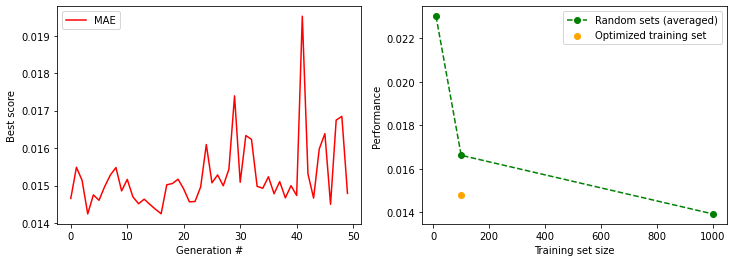

In [64]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
ay = fig.add_subplot(1,2,2)

ax.plot(np.arange(n_generations), -all_op['score'], 'r-', label='MAE')
ax.legend()
ax.set_xlabel('Generation #')
ax.set_ylabel('Best score')

rand_mae = results['mae'][1]
opt_mae = all_op['score'][n_generations-1]

ay.plot(results['train_size'], results['mae'], 'g--o', label="Random sets (averaged)")
ay.scatter(100, -opt_mae, facecolor='orange', label = "Optimized training set")
ay.legend()
ay.set_xlabel('Training set size')
ay.set_ylabel('Performance')

print("The MAE of the model using the optimized training set of 100 entries was {:.3f}, while the one averaged over 4 random training sets of 100 entries was {:.3f}, which represents a reduction of {:.1f}% of the MAE". format(
    -test_mae, rand_mae, (rand_mae+opt_mae)/rand_mae*100))